In [1]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.1 MB/s eta 0:00:00


In [2]:
!pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [3]:
!pip install shimmy>=2.0

In [4]:
import gym
import numpy as np
import pandas as pd
import seaborn as sns
from gym import spaces
import geopandas as gpd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from scipy.stats import f_oneway
from stable_baselines3 import PPO
from sklearn.cluster import KMeans
from lightgbm import LGBMRegressor
from shapely.geometry import Point
from statsmodels.formula.api import ols
from scipy.stats import chi2_contingency
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

/usr/local/lib/python3.11/dist-packages/geopandas/_compat.py:7: DeprecationWarning: The 'shapely.geos' module is deprecated, and will be removed in a future version. All attributes of 'shapely.geos' are available directly from the top-level 'shapely' namespace (since shapely 2.0.0).
  import shapely.geos


Find variables using ML models. Use them with other columns to find sustainability score. Higher score means better location

Sustainability score for data center = x(Environmental impact)+y(Renewable profile)+z(Infrastructure proximity)

Create an optimization problem for dynamically alloting the coefficiants to each of the factors based on the region.

Environmental impact = carbon intensity + Water intensity = $\frac{CO_2e\text{ emission}}{\text{Net generation(MWh)}}$ + Water Intensity

Renewable profile = contribution of renewable energy = $\frac{\text{total PCA generation from renewable energy}}{\text{total PCA generation}}$

Infrastructure proximity = Grid stability = ($\frac{\text{PCA generation}}{\text{Total scaled power generation}}$ + Plants per balancing authority + fuel type infrastructure complexity)


In [5]:
df_sheets = pd.read_excel("Input data.xlsx", sheet_name=None)

In [6]:
pd.set_option('display.max_colwidth', None)


In [7]:
df_sheet1 = df_sheets["TOC"]
print(df_sheet1)

  List of tables  \
0            NaN   
1        Table 1   
2        Table 2   
3        Table 3   
4        Table 4   
5        Table 5   
6        Table 6   

                                                                            Unnamed: 1  
0                                                                                  NaN  
1    Scalled energy use by data center type from the Power Control Authorities (PCAs).  
2                                Water and carbon intensity of power plants in the US.  
3  Inter PCA electricity transfers to match electricity supply with electricity demand  
4                                              Spatial join of subbasins with the PCAs  
5                                            Characterization factors of the subbasins  
6                               Scalled energy use by data centers from the US States.  


In [8]:
df1 = df_sheets['Table 1']
df1.columns = ['PCA Name', 'Internal Data Centers Scaled power Consumption 2018 (MWh)', 'Colocation data center Scaled Power Consumption 2018 (MWh)', 'Hyperscale data center Scaled Power Consumption 2018 (MWh)', 'Total Scaled Power Consumption (MWh)']
df1 = df1[3:].reset_index(drop=True)
df1

,PCA Name,Internal Data Centers Scaled power Consumption 2018 (MWh),Colocation data center Scaled Power Consumption 2018 (MWh),Hyperscale data center Scaled Power Consumption 2018 (MWh),Total Scaled Power Consumption (MWh)
0,"Alcoa Power Generating, Inc. - Yadkin Division",923.350417,278.208552,283.613404,1485.172374
1,Anchorage Municipal Light & Power,34519.008414,0,0,34519.008414
2,Arizona Public Service Company,29418.7276,86543.621606,88089.328184,204051.677389
3,"Arlington Valley, LLC - AVBA",3173.747194,10430.744529,10617.092661,24221.584384
4,"Associated Electric Cooperative, Inc.",33689.491674,6205.711663,6316.120266,46211.323604
...,...,...,...,...,...
68,Turlock Irrigation District,26044.394227,18487.373539,18817.998147,63349.765913
69,Western Area Power Administration - Desert Southwest Region,296287.097429,323804.650252,329586.639356,949678.387037
70,Western Area Power Administration - Rocky Mountain Region,168204.778329,95200.267568,96900.251272,360305.297169
71,Western Area Power Administration UGP West,6137.638283,3190.055527,3247.124693,12574.818504


In [9]:
df2 = df_sheets['Table 2']
df2.columns = df2.iloc[1]
df2 = df2[2:].reset_index(drop=True)
df2

1,Plant state,Plant name,Plant Id,Balancing Authority Name,Balancing Authority Code,PCA Generation (MWh),Latitude,Longitude,Plant primary fuel,Plant primary fuel code,Net generation (MWh),CO2-e Emission (tons),Water intensity (m3/MWh),Carbon intensity (Tons/MWh),Generation Ratio of Power plant,Water Consumption (m3),Subbasin,HUC8,HUC8 ID
0,AL,ABC Coke,56076,"Southern Company Services, Inc. - Trans",SOCO,255414543.497,33.582793,-86.779866,COG,COAL,5290,1552.988,1.847267,0.293571,0.000021,9772.043741,Locust,03160111,3160111
1,AL,Alabama Pine Pulp,54429,"Southern Company Services, Inc. - Trans",SOCO,255414543.497,31.5825,-87.4889,BLQ,BIOMASS,413079.77,10436.106,1.937552,0.025264,0.001617,800363.491644,Lower Alabama,03150204,3150204
2,AL,Alabama River Pulp,10216,"Southern Company Services, Inc. - Trans",SOCO,255414543.497,31.5825,-87.4889,BLQ,BIOMASS,308063.28,12986.077,1.937552,0.042154,0.001206,596888.592313,Lower Alabama,03150204,3150204
3,AL,AMEA Sylacauga Plant,56018,"Southern Company Services, Inc. - Trans",SOCO,255414543.497,33.1661,-86.2825,NG,GAS,34570,22786.699,0.797026,0.659147,0.000135,27553.194096,Lower Coosa,03150107,3150107
4,AL,ANAD Solar Array,60680,"Southern Company Services, Inc. - Trans",SOCO,255414543.497,33.626728,-85.969481,SUN,SOLAR,17168,0,0.0076,0,0.000067,130.4768,Middle Coosa,03150106,3150106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8398,WY,Western Sugar Coop - Torrington,57967,Western Area Power Administration - Rocky Mountain Region,WACM,45162128.319,42.0469,-104.1863,NG,GAS,6262.32,2141.555,0.797026,0.341975,0.000139,4991.232816,Middle North Platte-Scotts Bluff,10180009,10180009
8399,WY,Wygen I,55479,Western Area Power Administration - Rocky Mountain Region,WACM,45162128.319,44.2858,-105.3833,SUB,COAL,639452,837289.793,1.847267,1.309386,0.014159,1181238.736213,Upper Belle Fourche,10120201,10120201
8400,WY,Wygen II,56319,Western Area Power Administration - Rocky Mountain Region,WACM,45162128.319,44.2919,-105.3811,SUB,COAL,769549,989898.885,1.847267,1.286336,0.01704,1421562.663365,Upper Belle Fourche,10120201,10120201
8401,WY,Wygen III,56596,Western Area Power Administration - Rocky Mountain Region,WACM,45162128.319,44.2919,-105.3806,SUB,COAL,852015,1070965.4,1.847267,1.25698,0.018866,1573899.404232,Upper Belle Fourche,10120201,10120201


In [10]:
df4 = df_sheets['Table 4']
df4.columns = df4.iloc[1]
df4 = df4[2:].reset_index(drop=True)
df4

1,Subbasin,HUC8,Subbasin Area (m2),HUC8 ID,PCA Name
0,Upper St. John,01010001,17222890136.599998,1010001,ISO New England Inc.
1,Upper St. John,01010001,17222890136.599998,1010001,New Brunswick System Operator
2,Allagash,01010002,3198097222.04,1010002,ISO New England Inc.
3,Allagash,01010002,3198097222.04,1010002,New Brunswick System Operator
4,Fish,01010003,2304014818.42,1010003,ISO New England Inc.
...,...,...,...,...,...
2968,Whitewater River,18100201,3886349590.72,18100201,California Independent System Operator
2969,Carrizo Creek,18100202,1818917328.07,18100202,California Independent System Operator
2970,San Felipe Creek,18100203,2390774785.12,18100203,California Independent System Operator
2971,Salton Sea,18100204,10459920945,18100204,Western Area Power Administration - Desert Southwest Region


In [11]:
df5 = df_sheets['Table 5']
df5.columns = df5.iloc[1]
df5 = df5[2:].reset_index(drop=True)
df5

1,HUC8 ID,Subbasin,Scaled Power Consumption (MWh),Characterization factor
0,1010001,Upper St. John,887.732534,0.240074
1,1010002,Allagash,0,0.334706
2,1010003,Fish,1242.825547,0.311171
3,1010004,Aroostook,1953.011574,0.309205
4,1010005,Meduxnekeag,1597.918561,0.277446
...,...,...,...,...
2094,18100100,Southern Mojave,19117.122316,100
2095,18100201,Whitewater River,42482.494895,20.27964
2096,18100202,Carrizo Creek,10074.259296,46.577097
2097,18100203,San Felipe Creek,5482.21108,31.673298


#Merging Relevant Columns on the Dataset

In [12]:
df2_5 = pd.merge(
    df2,
    df5[['HUC8 ID', 'Characterization factor']],  # Extract relevant columns from Table 5
    on='HUC8 ID',
    how='left'
)

# Step 2: Merge the result with Table 4 using HUC8 ID
df2_5_4 = pd.merge(
    df2_5,
    df4[['HUC8 ID', 'PCA Name']],  # Extract relevant columns from Table 4
    on='HUC8 ID',
    how='left'
)

# Step 3: Merge with Table 1 using PCA Name
df1_2_4_5 = pd.merge(
    df2_5_4,
    df1[['PCA Name', 'Total Scaled Power Consumption (MWh)']],  # Extract relevant columns from Table 1
    on='PCA Name',
    how='left'
)

# df1_2_4_5 = df1_2_4_5.loc[df1_2_4_5['Water intensity (m3/MWh)'] > 0]

print(df1_2_4_5)


      Plant state                       Plant name Plant Id  \
0              AL                         ABC Coke    56076   
1              AL                Alabama Pine Pulp    54429   
2              AL               Alabama River Pulp    10216   
3              AL             AMEA Sylacauga Plant    56018   
4              AL             AMEA Sylacauga Plant    56018   
...           ...                              ...      ...   
10948          WY  Western Sugar Coop - Torrington    57967   
10949          WY                          Wygen I    55479   
10950          WY                         Wygen II    56319   
10951          WY                        Wygen III    56596   
10952          WY                           Wyodak     6101   

                                        Balancing Authority Name  \
0                        Southern Company Services, Inc. - Trans   
1                        Southern Company Services, Inc. - Trans   
2                        Southern Compa

In [13]:
print(df1_2_4_5['Plant primary fuel code'].unique())

['COAL' 'BIOMASS' 'GAS' 'SOLAR' 'HYDRO' 'NUCLEAR' 'OIL' 'WIND'
 'GEOTHERMAL' 'OTHF' 'OFSL']


#Feature Engineering for ML Models

In [14]:
# Create renewable energy indicator
renewable_fuels = ['SOLAR', 'WIND', 'HYDRO', 'GEOTHERMAL', 'BIOMASS']
# Create fuel type categories (fossil, renewable, nuclear, etc.)
def categorize_fuel(fuel_code):
    if fuel_code in ['COAL', 'GAS', 'OIL']:
        return 'Fossil'
    elif fuel_code in renewable_fuels:
        return 'Renewable'
    elif fuel_code == 'NUCLEAR':
        return 'Nuclear'
    else:
        return 'Other'

df1_2_4_5['Fuel_Category'] = df1_2_4_5['Plant primary fuel code'].apply(categorize_fuel)

def fuel_category_calc(fuel_code):
    return categorize_fuel(fuel_code)

In [15]:
# Calculate water efficiency ratio (output vs water usage)
df1_2_4_5['Water_Efficiency_Ratio'] = df1_2_4_5['Net generation (MWh)'] / (df1_2_4_5['Water Consumption (m3)'] + 1)

def water_efficiency_ratio_calc(net_gen, water_cons):
    return net_gen/(water_cons+1)

#Handling Missing Values

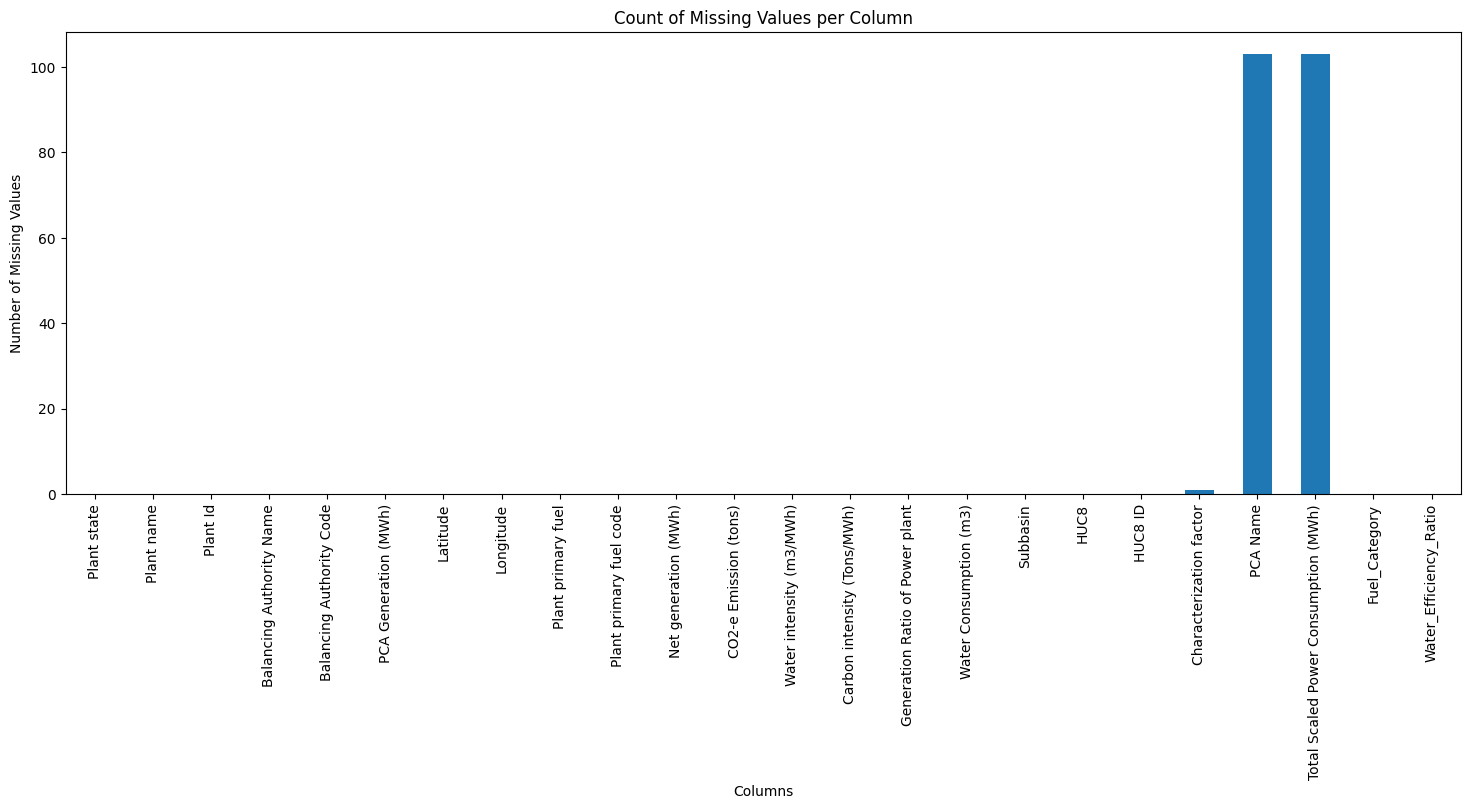

In [16]:
plt.figure(figsize=(18, 6))
df1_2_4_5.isnull().sum().plot(kind='bar')
plt.title('Count of Missing Values per Column')
plt.ylabel('Number of Missing Values')
plt.xlabel('Columns')
plt.show()

In [17]:
df1_2_4_5 = df1_2_4_5.drop(['Plant name', 'Balancing Authority Name', 'Plant primary fuel', 'HUC8'], axis=1)

In [18]:
df1_2_4_5 = df1_2_4_5.drop(['Subbasin'], axis=1)

In [19]:
numericCols = ['PCA Generation (MWh)', 'Net generation (MWh)', 'Water intensity (m3/MWh)', 'Water Consumption (m3)',
             'Latitude', 'Longitude', 'Characterization factor', 'Total Scaled Power Consumption (MWh)', 'CO2-e Emission (tons)',
       'Carbon intensity (Tons/MWh)', 'Generation Ratio of Power plant','Characterization factor', 'Total Scaled Power Consumption (MWh)', 'Regional_Avg_Emission',
       'Efficiency_Ratio','Regional_Avg_Water_Intensity', 'Water_Efficiency_Ratio', 'total_gen',
       'renew_gen', 'renewable_fraction', 'Capacity Utilization',
       'Infrastructure Complexity', 'Plants per BA', 'Infrastructure score']

In [20]:
# Ensure all numeric columns are numeric
for numericCol in numericCols:
  if numericCol in df1_2_4_5.columns:
    df1_2_4_5[numericCol] = pd.to_numeric(df1_2_4_5[numericCol], errors='coerce')

# Create imputers for numeric and categorical data
numeric_cols = df1_2_4_5.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df1_2_4_5.select_dtypes(include=['object']).columns
print('Numerical columns: ', numeric_cols)
print('Categorical columns: ', categorical_cols)



Numerical columns:  Index(['PCA Generation (MWh)', 'Latitude', 'Longitude', 'Net generation (MWh)',
       'CO2-e Emission (tons)', 'Water intensity (m3/MWh)',
       'Carbon intensity (Tons/MWh)', 'Generation Ratio of Power plant',
       'Water Consumption (m3)', 'Characterization factor',
       'Total Scaled Power Consumption (MWh)', 'Water_Efficiency_Ratio'],
      dtype='object')
Categorical columns:  Index(['Plant state', 'Plant Id', 'Balancing Authority Code',
       'Plant primary fuel code', 'HUC8 ID', 'PCA Name', 'Fuel_Category'],
      dtype='object')


In [21]:
# For numeric columns, impute with mean
numeric_imputer = SimpleImputer(strategy='mean')
df1_2_4_5[numeric_cols] = numeric_imputer.fit_transform(df1_2_4_5[numeric_cols])

# For categorical columns, impute with most frequent value
categorical_imputer = SimpleImputer(strategy='most_frequent')
df1_2_4_5[categorical_cols] = categorical_imputer.fit_transform(df1_2_4_5[categorical_cols])

In [22]:
df1_2_4_5.columns

Index(['Plant state', 'Plant Id', 'Balancing Authority Code',
       'PCA Generation (MWh)', 'Latitude', 'Longitude',
       'Plant primary fuel code', 'Net generation (MWh)',
       'CO2-e Emission (tons)', 'Water intensity (m3/MWh)',
       'Carbon intensity (Tons/MWh)', 'Generation Ratio of Power plant',
       'Water Consumption (m3)', 'HUC8 ID', 'Characterization factor',
       'PCA Name', 'Total Scaled Power Consumption (MWh)', 'Fuel_Category',
       'Water_Efficiency_Ratio'],
      dtype='object')

#Correlation for Variable Selection

## numeric-numeric relationship


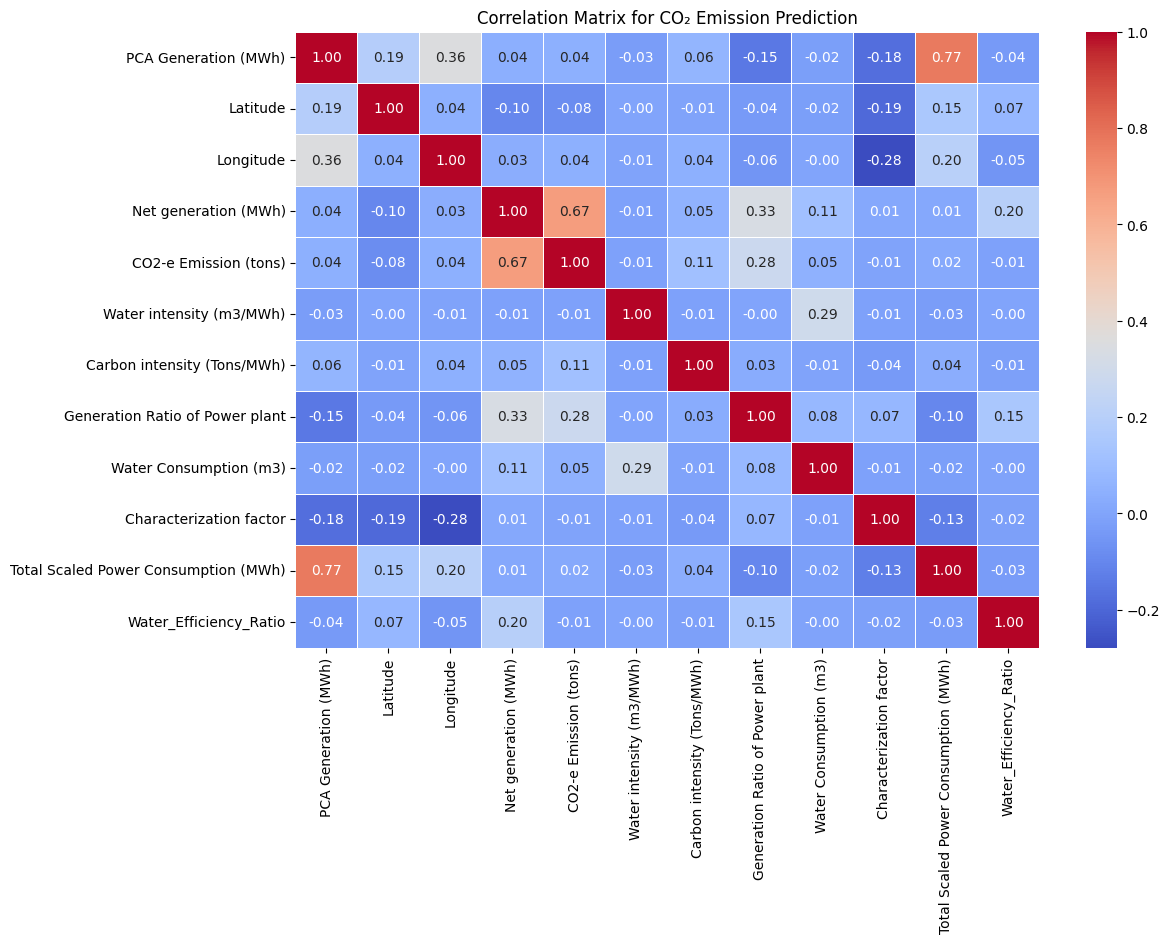

In [23]:
# correlation>0.7 => keep only one of the variables
# correlation with dependent variable < 0.2 => remove variable as noise

corr_matrix = df1_2_4_5[numeric_cols].corr(method='pearson')

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix for CO₂ Emission Prediction")
plt.show()

## categorical-categorical relationship

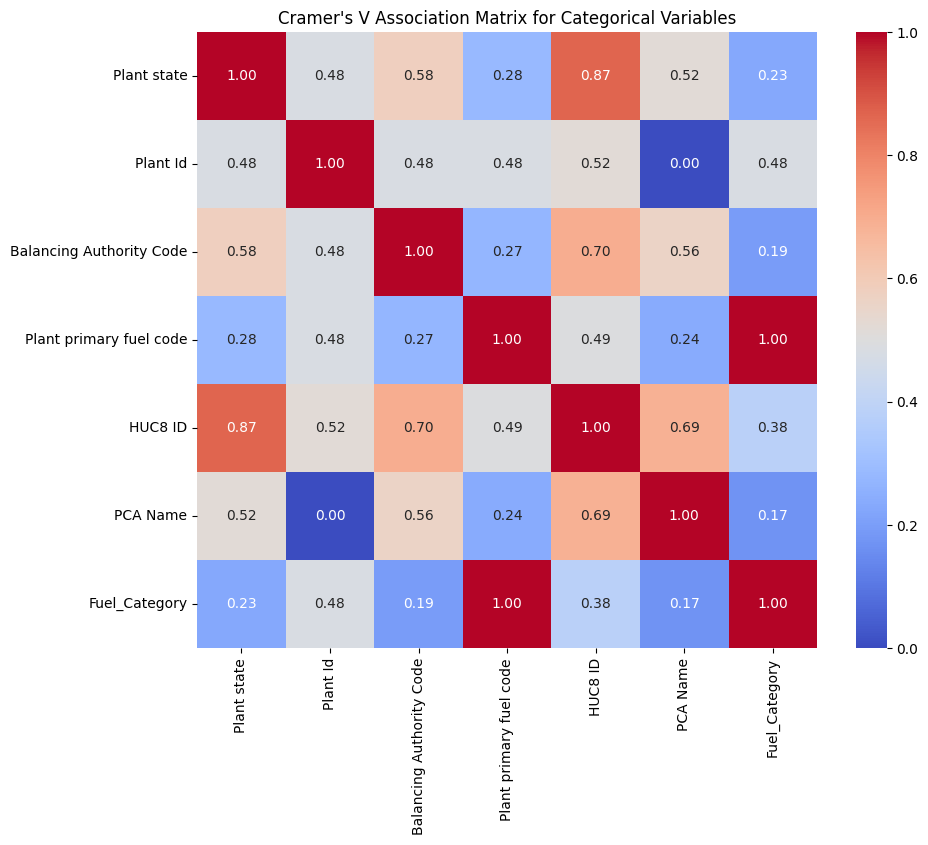

In [24]:
# categorical-categorical relationship


def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Initialize association matrix
assoc_matrix = pd.DataFrame(np.zeros((len(categorical_cols), len(categorical_cols))),
                            index=categorical_cols, columns=categorical_cols)

# Fill matrix with Cramer's V values
for i in categorical_cols:
    for j in categorical_cols:
        assoc_matrix.loc[i, j] = cramers_v(df1_2_4_5[i], df1_2_4_5[j])

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(assoc_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Cramer's V Association Matrix for Categorical Variables")
plt.show()


## Categorical variables for CO2 emissions


In [25]:
# (p < 0.05, η² ≥ 0.06)

def fast_anova_eta_squared(df, cat_var, target_var):
    """Optimized ANOVA with eta squared calculation."""
    groups = [group[target_var].values for name, group in df.groupby(cat_var)]
    f_stat, p_value = f_oneway(*groups)

    # Calculate eta squared
    k = len(groups)  # Number of groups
    n = len(df)      # Total sample size
    df_between = k - 1
    df_within = n - k
    eta_sq = (f_stat * df_between) / (f_stat * df_between + df_within)

    return f_stat, p_value, eta_sq


# Dictionary to store results
results = {}
for var in categorical_cols:
    try:
        f_stat, p_value, eta = fast_anova_eta_squared(df1_2_4_5, var, 'CO2-e Emission (tons)')
        results[var] = {
            'F-statistic': f_stat,
            'p-value': p_value,
            'eta_squared': eta
        }
    except Exception as e:
        results[var] = {'Error': str(e)}

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
print(results_df)


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


                          F-statistic        p-value  eta_squared
Plant state                 11.432880   9.447712e-84     0.047917
Plant Id                          inf   0.000000e+00          NaN
Balancing Authority Code     8.660547   2.888003e-80     0.050610
Plant primary fuel code    861.918115   0.000000e+00     0.440627
HUC8 ID                      4.713040   0.000000e+00     0.406769
PCA Name                     6.077689   3.464219e-40     0.029235
Fuel_Category              383.904371  4.150802e-237     0.095177


#Variables by ML calculations

##Geo Cluster

In [26]:

# Use Latitude/Longitude for spatial clustering
coords = df1_2_4_5[['Latitude', 'Longitude']]
geo_cluster_kmeans = KMeans(n_clusters=20, random_state=42)
df1_2_4_5['Geo_Cluster'] = geo_cluster_kmeans.fit_predict(coords)

# Create geographic clusters based on latitude/longitude
def geo_cluster_calc(lat, lon):
    return geo_cluster_kmeans.predict([[lat, lon]])[0]


###Result Visualization

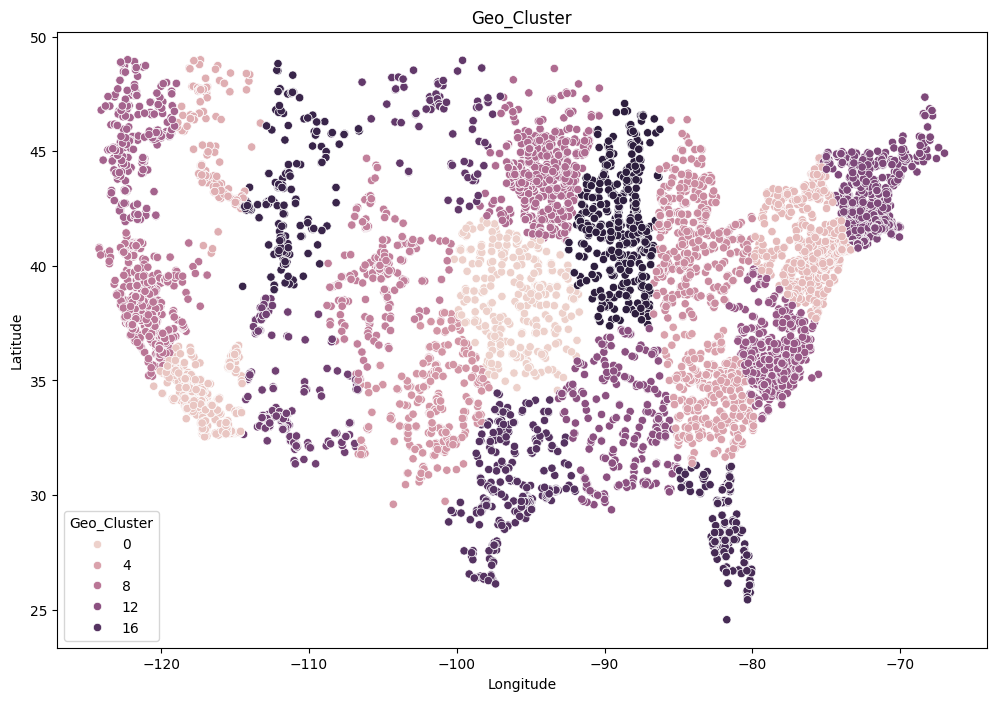

In [27]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='Longitude', y='Latitude', hue='Geo_Cluster', data=df1_2_4_5)
plt.title('Geo_Cluster')
plt.show()

##${CO_2}$e emission

In [54]:
dfCarbon = df1_2_4_5[['CO2-e Emission (tons)', 'Geo_Cluster', 'Fuel_Category', 'Net generation (MWh)', 'Generation Ratio of Power plant', 'Plant primary fuel code', 'HUC8 ID', 'Plant state', 'Balancing Authority Code']]

In [55]:
print(dfCarbon.columns)

Index(['CO2-e Emission (tons)', 'Geo_Cluster', 'Fuel_Category',
       'Net generation (MWh)', 'Generation Ratio of Power plant',
       'Plant primary fuel code', 'HUC8 ID', 'Plant state',
       'Balancing Authority Code'],
      dtype='object')


In [56]:
print(categorical_cols)

Index(['Plant state', 'Plant Id', 'Balancing Authority Code',
       'Plant primary fuel code', 'HUC8 ID', 'PCA Name', 'Fuel_Category'],
      dtype='object')


In [57]:
# Convert columns to string type (important for consistent encoding)
label_encoders = {}
for col in dfCarbon.columns:
  if col in categorical_cols:
    dfCarbon[col] = dfCarbon[col].astype(str)
    le = LabelEncoder()
    dfCarbon[col] = le.fit_transform(dfCarbon[col])
    label_encoders[col] = le  # Save encoder for future use (inverse_transform, etc.)

<ipython-input-57-f0773e463c52>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfCarbon[col] = dfCarbon[col].astype(str)
<ipython-input-57-f0773e463c52>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfCarbon[col] = le.fit_transform(dfCarbon[col])
<ipython-input-57-f0773e463c52>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [58]:
#  Train test split
y = dfCarbon['CO2-e Emission (tons)']
X = dfCarbon.drop(columns=['CO2-e Emission (tons)'])


# 8. Train-test split with spatial cross-validation to prevent data leak
splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
groups = dfCarbon['HUC8 ID']  # Group by watershed

for train_idx, test_idx in splitter.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [59]:
co2_emission_model = XGBRegressor(n_estimators=100, random_state=42, enable_categorical=True)
co2_emission_model.fit(X_train, y_train)

y_pred = co2_emission_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

def co2_emission_calc(net_gen, geo_cluster, fuel_category, gen_ratio, plant_fuel, huc8id, plant_state, bac):
    input_data = pd.DataFrame({
        'Geo_Cluster': [geo_cluster],  # Moved to the beginning to match the training order
        'Fuel_Category': [fuel_category],  # Moved to the beginning to match the training order
        'Net generation (MWh)': [net_gen],
        'Generation Ratio of Power plant': [gen_ratio],
        'Plant primary fuel code': [plant_fuel],
        'HUC8 ID': [huc8id],
        'Plant state': [plant_state],
        'Balancing Authority Code': [bac]
    })

    # ... (Rest of the code inside the function) ...

    # Ensure input_data column order matches training data order
    input_data = input_data[['Geo_Cluster', 'Fuel_Category', 'Net generation (MWh)', 'Generation Ratio of Power plant', 'Plant primary fuel code', 'HUC8 ID', 'Plant state', 'Balancing Authority Code']]

    # Convert Plant state back to numeric for prediction
    # This was inadvertently cast to string during label encoding
    # Handle unseen labels by adding them to the encoder
    if plant_state not in label_encoders['Plant state'].classes_:
        label_encoders['Plant state'].classes_ = np.append(label_encoders['Plant state'].classes_, plant_state)
    input_data['Plant state'] = label_encoders['Plant state'].transform(input_data['Plant state'])

    for col in categorical_cols:
        # Get the label encoder for the current column
        le = label_encoders[col]

        # Check if the value is in the known classes of the encoder
        if str(input_data[col].iloc[0]) in le.classes_:
            input_data[col] = le.transform(input_data[col].astype(str))
        else:
            # Handle unknown values - here, we'll assign a default value
            input_data[col] = -1  # You can choose a different default if needed

    prediction = co2_emission_model.predict(input_data)
    return prediction[0]

Mean Squared Error: 25341016218.9447
R² Score: 0.9837


###Result Visualization

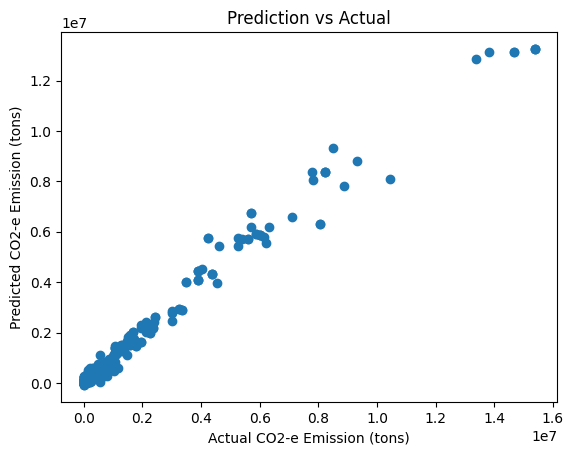

In [60]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual CO2-e Emission (tons)')
plt.ylabel('Predicted CO2-e Emission (tons)')
plt.title('Prediction vs Actual')
plt.show()


In [62]:
print(df1_2_4_5[['CO2-e Emission (tons)']].describe())

       CO2-e Emission (tons)
count           1.095300e+04
mean            2.530677e+05
std             1.257357e+06
min             0.000000e+00
25%             0.000000e+00
50%             0.000000e+00
75%             1.584277e+03
max             2.030317e+07


### Water intensity

###Categorical variables for Water Intensity

In [63]:
# (p < 0.05, η² ≥ 0.14)

def fast_anova_eta_squared(df, cat_var, target_var):
    """Optimized ANOVA with eta squared calculation."""
    groups = [group[target_var].values for name, group in df.groupby(cat_var)]
    f_stat, p_value = f_oneway(*groups)

    # Calculate eta squared
    k = len(groups)  # Number of groups
    n = len(df)      # Total sample size
    df_between = k - 1
    df_within = n - k
    eta_sq = (f_stat * df_between) / (f_stat * df_between + df_within)

    return f_stat, p_value, eta_sq


# Dictionary to store results
results = {}
for var in categorical_cols:
    try:
        f_stat, p_value, eta = fast_anova_eta_squared(df1_2_4_5, var, 'Water intensity (m3/MWh)')
        results[var] = {
            'F-statistic': f_stat,
            'p-value': p_value,
            'eta_squared': eta
        }
    except Exception as e:
        results[var] = {'Error': str(e)}

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
print(results_df)


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


                          F-statistic        p-value  eta_squared
Plant state                  1.008068   4.574155e-01     0.004418
Plant Id                          inf   0.000000e+00          NaN
Balancing Authority Code    19.229886  1.535690e-211     0.105837
Plant primary fuel code     14.791679   1.557564e-26     0.013338
HUC8 ID                      1.886763   1.810377e-64     0.215378
PCA Name                     9.975621   8.605566e-79     0.047101
Fuel_Category                4.024564   7.155168e-03     0.001102


###Prediction

In [64]:
dfWater = df1_2_4_5[['Water intensity (m3/MWh)', 'Fuel_Category', 'Water_Efficiency_Ratio', 'Water Consumption (m3)', 'HUC8 ID', 'Balancing Authority Code', 'Plant primary fuel code', 'Net generation (MWh)']]

In [65]:
# Prepare features and target
y = dfWater['Water intensity (m3/MWh)']
X = dfWater.drop(columns=['Water intensity (m3/MWh)'])

# Encode categorical variables
categorical_cols = ['HUC8 ID', 'Balancing Authority Code', 'Plant primary fuel code', 'Fuel_Category']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Spatial cross-validation split
splitter = GroupShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
groups = X['HUC8 ID']  # Prevent leakage between watersheds

for train_idx, test_idx in splitter.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]


encoder = TargetEncoder(cols=['HUC8 ID', 'Balancing Authority Code'])
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.transform(X_test)


water_intensity_model = LGBMRegressor(objective='regression', metric='r2', random_state=42, n_estimators=200, learning_rate=0.081)
# Mean Squared Error: 12393.1129
# R² Score: 0.5978

water_intensity_model.fit(X_train, y_train)

# Evaluate
y_pred = water_intensity_model.predict(X_test)
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.4f}")
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")

def water_intensity_calc(water_cons, fuel_category, water_efficiency, huc8id, bac, plant_fuel, net_gen):
    input_df = pd.DataFrame({
        'HUC8 ID': [huc8id],
        'Balancing Authority Code': [bac],
        'Plant primary fuel code': [plant_fuel],
        'Net generation (MWh)': [net_gen],
        'Water Consumption (m3)': [water_cons],
        'Water_Efficiency_Ratio': [water_efficiency],
        'Fuel_Category': [fuel_category],
        })

    # Step 1: Label encode categorical variables using the pre-trained encoders
    for col in ['HUC8 ID', 'Balancing Authority Code', 'Plant primary fuel code']:
        le = label_encoders[col]
        # Handle unseen labels by adding them to the encoder
        if str(input_df[col].iloc[0]) not in le.classes_:
            # Add the new label to the classes_ attribute of the encoder
            le.classes_ = np.append(le.classes_, str(input_df[col].iloc[0]))
        input_df[col] = le.transform(input_df[col].astype(str))

    # Step 2: Apply target encoding to HUC8 ID and BAC (as done during training)
    input_df = encoder.transform(input_df)

    # Step 3: Predict
    prediction = water_intensity_model.predict(input_df)
    return prediction[0]  # Return scalar instead of array

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1095
[LightGBM] [Info] Number of data points in the train set: 8934, number of used features: 7
[LightGBM] [Info] Start training from score 23.634367
Mean Squared Error: 15862.6893
R² Score: 0.5896


In [66]:
print(df1_2_4_5['Water intensity (m3/MWh)'].describe())


count    10953.000000
mean        23.103579
std        425.610592
min          0.000000
25%          0.007600
50%          0.007600
75%          1.847267
max      22345.902388
Name: Water intensity (m3/MWh), dtype: float64


# Feature Engineering

In [35]:
group_col = 'Balancing Authority Code'

# Compute total and renewable generation per group
gen_by_pca = df1_2_4_5.groupby(group_col)['Net generation (MWh)'].sum().rename('total_gen')
renew_by_pca = df1_2_4_5[df1_2_4_5['Fuel_Category']=='Renewable'].groupby(group_col)['Net generation (MWh)'].sum().rename('renew_gen')

df1_2_4_5 = df1_2_4_5.merge(gen_by_pca, on=group_col, how='left')
df1_2_4_5 = df1_2_4_5.merge(renew_by_pca, on=group_col, how='left')
df1_2_4_5['renewable_fraction'] = df1_2_4_5['renew_gen'] / df1_2_4_5['total_gen']

def get_renewable_fraction(group_col, target_bac):
    group_col = 'Balancing Authority Code'
    # Filter for the target BAC and get first occurrence (all will have same value)
    result = df1_2_4_5[df1_2_4_5[group_col] == target_bac]
    if not result.empty:
        return result['renewable_fraction'].iloc[0]
    else:
        print(f"Warning: {target_bac} not found in dataset")
        return None

In [36]:
# All variables scaled down to range of 100
df1_2_4_5['Capacity Utilization'] = df1_2_4_5['PCA Generation (MWh)'] / df1_2_4_5['Total Scaled Power Consumption (MWh)']
df1_2_4_5['Capacity Utilization'] = (df1_2_4_5['Capacity Utilization']-df1_2_4_5['Capacity Utilization'].min())/(df1_2_4_5['Capacity Utilization'].max()-df1_2_4_5['Capacity Utilization'].min())*100
fuel_weights = {'COAL': 100.0, 'NUCLEAR': 95, 'OTHF': 85, 'OFSL':80, 'BIOMASS': 80, 'OIL': 75, 'GAS': 70, 'HYDRO': 60, 'GEOTHERMAL':50, 'WIND': 35, 'SOLAR': 0.30}
df1_2_4_5['Infrastructure Complexity'] = df1_2_4_5['Plant primary fuel code'].map(fuel_weights)
df1_2_4_5['Plants per BA'] = df1_2_4_5.groupby('Balancing Authority Code')['Plant Id'].transform('count')
df1_2_4_5['Plants per BA'] = (df1_2_4_5['Plants per BA']-df1_2_4_5['Plants per BA'].min())/(df1_2_4_5['Plants per BA'].max()-df1_2_4_5['Plants per BA'].min())*100
df1_2_4_5['Infrastructure score'] = df1_2_4_5['Capacity Utilization'] + df1_2_4_5['Infrastructure Complexity'] + df1_2_4_5['Plants per BA']
# Scale to 0-1 range (very small difference so cancelling)
# df1_2_4_5['Infra score'] = (df1_2_4_5['Infra score'] - df1_2_4_5['Infra score'].min()) / (df1_2_4_5['Infra score'].max() - df1_2_4_5['Infra score'].min())
print(df1_2_4_5)

def get_infrastructure_score(fuel_code, bac, plant_id):
    # Filter for the plant
    plant_row = df1_2_4_5[
        (df1_2_4_5['Plant primary fuel code'] == fuel_code) &
        (df1_2_4_5['Balancing Authority Code'] == bac) &
        (df1_2_4_5['Plant Id'] == plant_id)
    ]

    if not plant_row.empty:
        return plant_row['Infrastructure score'].iloc[0]
    else:
        print("No matching plant found with the given details.")
        return None

      Plant state Plant Id  ... Plants per BA  Infrastructure score
0              AL    56076  ...     17.293689            117.294089
1              AL    54429  ...     17.293689             97.294089
2              AL    10216  ...     17.293689             97.294089
3              AL    56018  ...     17.293689             87.294089
4              AL    56018  ...     17.293689             87.325552
...           ...      ...  ...           ...                   ...
10948          WY    57967  ...      8.313107             78.313616
10949          WY    55479  ...      8.313107            108.313616
10950          WY    56319  ...      8.313107            108.313616
10951          WY    56596  ...      8.313107            108.313616
10952          WY     6101  ...     14.259709            114.260377

[10953 rows x 27 columns]


In [37]:
df1_2_4_5.columns

Index(['Plant state', 'Plant Id', 'Balancing Authority Code',
       'PCA Generation (MWh)', 'Latitude', 'Longitude',
       'Plant primary fuel code', 'Net generation (MWh)',
       'CO2-e Emission (tons)', 'Water intensity (m3/MWh)',
       'Carbon intensity (Tons/MWh)', 'Generation Ratio of Power plant',
       'Water Consumption (m3)', 'HUC8 ID', 'Characterization factor',
       'PCA Name', 'Total Scaled Power Consumption (MWh)', 'Fuel_Category',
       'Water_Efficiency_Ratio', 'Geo_Cluster', 'total_gen', 'renew_gen',
       'renewable_fraction', 'Capacity Utilization',
       'Infrastructure Complexity', 'Plants per BA', 'Infrastructure score'],
      dtype='object')

# Data Visualization

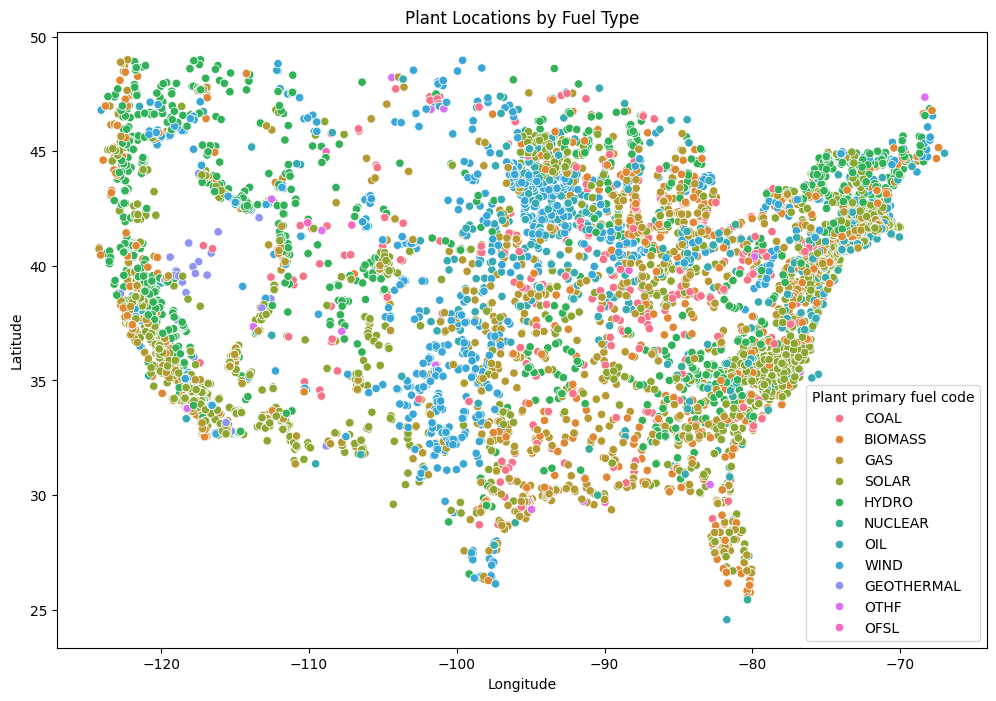

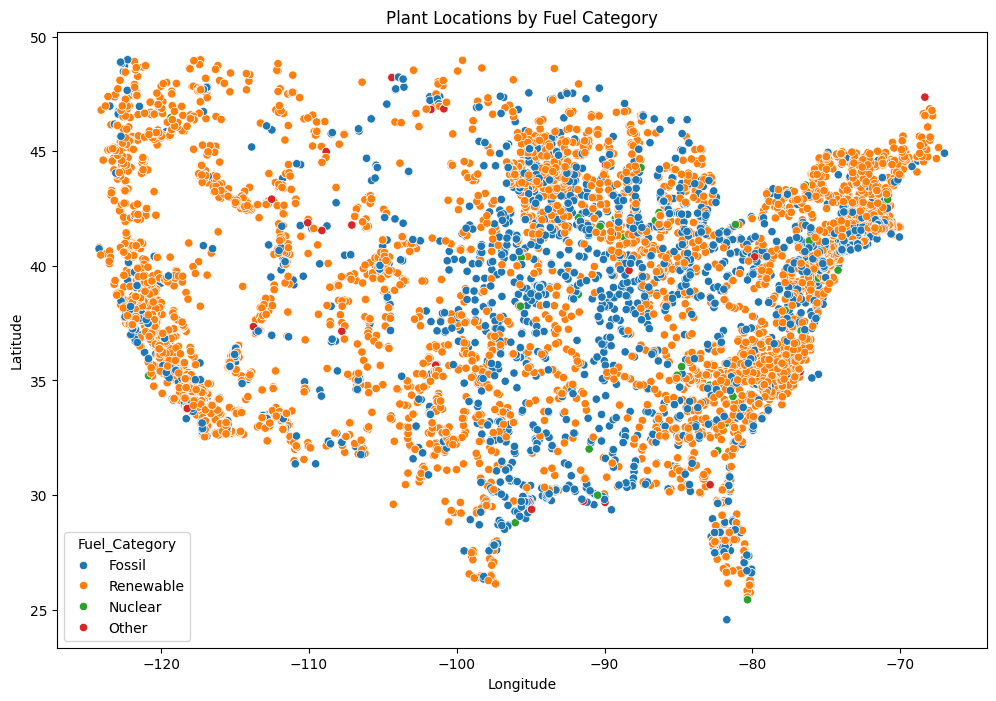

In [38]:
plt.figure(figsize=(12,8))
sns.scatterplot(x='Longitude', y='Latitude', hue='Plant primary fuel code', data=df1_2_4_5)
plt.title('Plant Locations by Fuel Type')
plt.show()

plt.figure(figsize=(12,8))
sns.scatterplot(x='Longitude', y='Latitude', hue='Fuel_Category', data=df1_2_4_5)
plt.title('Plant Locations by Fuel Category')
plt.show()


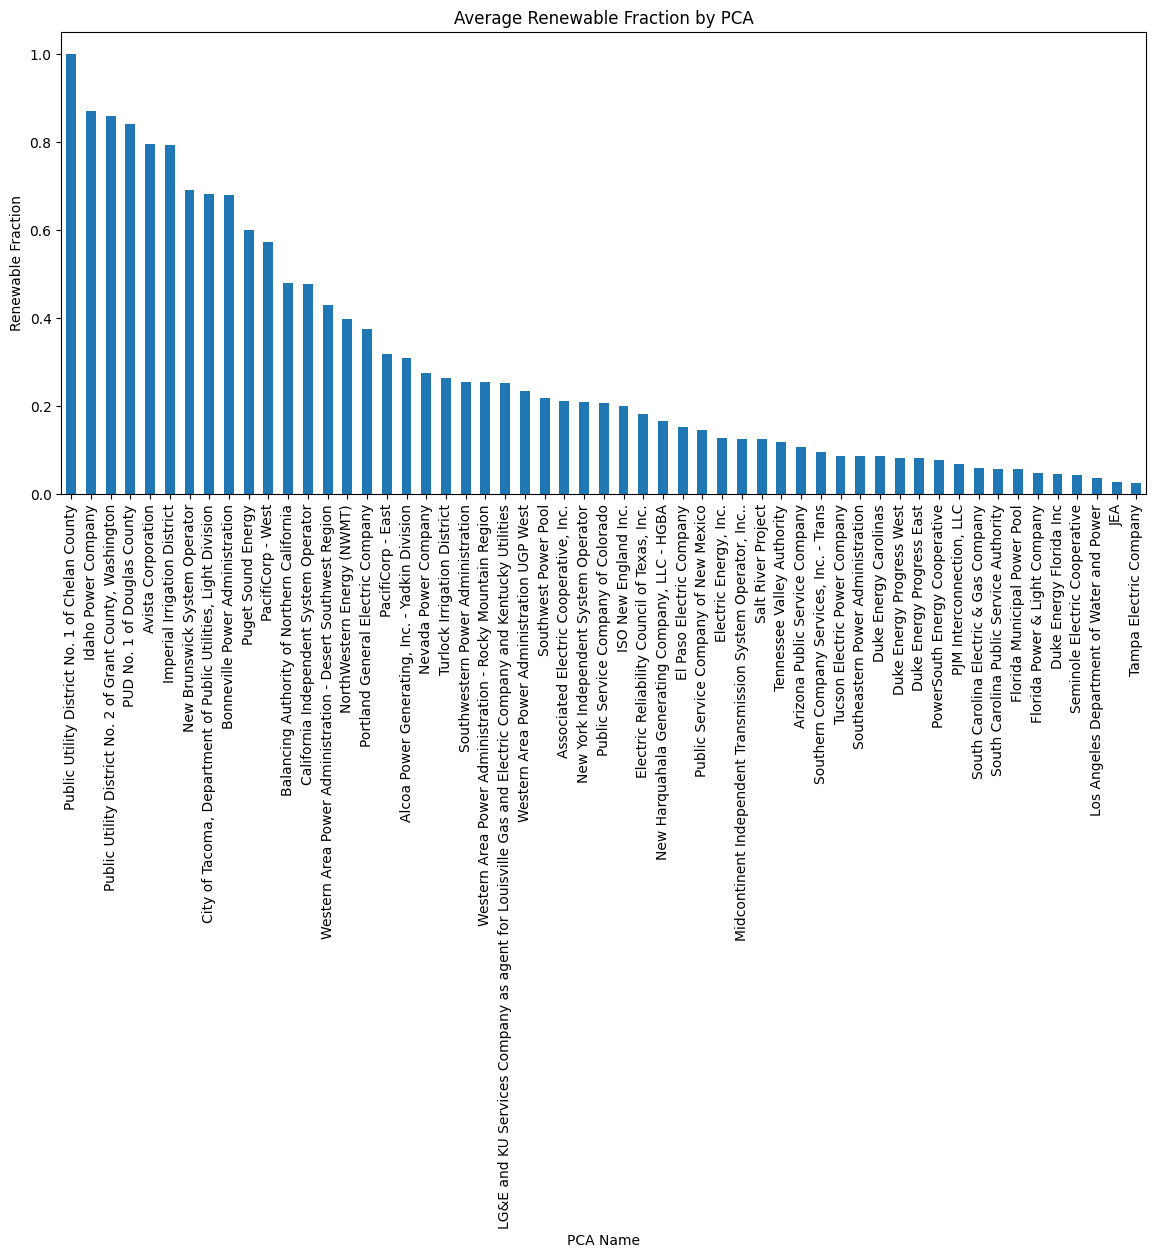

In [39]:
renewable_by_pca = df1_2_4_5.groupby('PCA Name')['renewable_fraction'].mean().sort_values(ascending=False)
renewable_by_pca.plot(kind='bar', figsize=(14,6))
plt.ylabel('Renewable Fraction')
plt.title('Average Renewable Fraction by PCA')
plt.show()

#Sustainability Score Calculation

In [40]:
def sustainability_score(carbon_intensity, water_intensity, renewable_profile, grid_stability, weights=[1, 1, 1]) -> float:
    environmental_impact = carbon_intensity + water_intensity
    infrastructure_proximity = grid_stability

    # Normalize weights to sum to 1
    x, y, z = weights / np.sum(weights)

    return x*environmental_impact + y*renewable_profile + z*infrastructure_proximity

def get_optimized_weights(carbon_intensity, water_intensity, renewable_profile, grid_stability, model, min_values, max_values) -> np.ndarray:
    # Normalize inputs using training data min/max
    metrics = np.array([
        carbon_intensity,
        water_intensity,
        renewable_profile,
        grid_stability,
    ])
    metrics_normalized = (metrics - min_values) / (max_values - min_values)

    # Predict weights
    action, _ = model.predict(metrics_normalized)
    return action / np.sum(action)  # Ensure weights sum to 1


In [65]:
class SustainabilityEnv(gym.Env):
    def __init__(self, carbon_int, water_int, ren_fraction, infra_score):
        super(SustainabilityEnv, self).__init__()

        # Regional data
        self.carbon_int = carbon_int
        self.water_int = water_int
        self.ren_fraction = ren_fraction
        self.infra_score = infra_score

        # Action space: constrained to 0.1-0.7 range
        self.action_space = spaces.Box(low=0.1, high=0.7, shape=(3,), dtype=np.float32)

        # State space
        self.observation_space = spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)

    def reset(self):
        # Same implementation as you have
        random_index = np.random.choice(len(self.carbon_int))
        self.carbon_int_current = self.carbon_int.iloc[random_index]
        self.water_int_current = self.water_int.iloc[random_index]
        self.ren_fraction_current = self.ren_fraction.iloc[random_index]
        self.infra_score_current = self.infra_score.iloc[random_index]

        return np.array([
            self.carbon_int_current,
            self.water_int_current,
            self.ren_fraction_current,
            self.infra_score_current
        ], dtype=np.float32)

    def step(self, action):
        # Apply constraints: ensure weights are between 0.1 and 0.7
        action = np.clip(action, 0.1, 0.7)

        # Normalize to sum to 1
        weights = action / np.sum(action)

        # To strictly enforce min/max after normalization (optional)
        if np.any(weights < 0.1) or np.any(weights > 0.7):
            # Constrain again and re-normalize iteratively
            for _ in range(5):  # Limit iterations
                weights = np.clip(weights, 0.1, 0.7)
                weights = weights / np.sum(weights)

                # Check if constraints are satisfied
                if np.all(weights >= 0.1) and np.all(weights <= 0.7):
                    break

        # Calculate sustainability score
        environmental_impact = self.carbon_int_current + self.water_int_current
        renewable_profile = self.ren_fraction_current
        infrastructure_proximity = self.infra_score_current

        score = (
            weights[0] * environmental_impact +
            weights[1] * renewable_profile +
            weights[2] * infrastructure_proximity
        )

        # Reward calculation
        reward = score - 0.1 * np.sum(np.abs(weights - 0.33))

        # Terminal condition
        done = False

        observation = np.array([
            self.carbon_int_current,
            self.water_int_current,
            self.ren_fraction_current,
            self.infra_score_current
        ], dtype=np.float32)

        return observation, reward, done, {}


In [66]:

# Select columns to normalize
cols_to_normalize = ['CO2-e Emission (tons)', 'Water intensity (m3/MWh)',
                    'renewable_fraction', 'Infrastructure score']

# Initialize scaler
scaler = MinMaxScaler()

# Normalize selected columns
df1_2_4_5[cols_to_normalize] = scaler.fit_transform(df1_2_4_5[cols_to_normalize])

# --- Check and handle NaNs and infinities after normalization ---
for col in cols_to_normalize:
    # Replace NaNs with 0
    df1_2_4_5[col].fillna(0, inplace=True)
    # Replace infinities with a large finite value (e.g., 1e10)
    df1_2_4_5[col].replace([np.inf, -np.inf], 1e10, inplace=True)

# Initialize environment and model
env = SustainabilityEnv(df1_2_4_5['CO2-e Emission (tons)'], df1_2_4_5['Water intensity (m3/MWh)'], df1_2_4_5['renewable_fraction'], df1_2_4_5['Infrastructure score'])
model = PPO('MlpPolicy', env, verbose=1)

# Train for 10,000 timesteps
model.learn(total_timesteps=10000)

# Save the model
model.save("sustainability_optimizer")

<ipython-input-66-f8110caa54ba>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1_2_4_5[col].fillna(0, inplace=True)
<ipython-input-66-f8110caa54ba>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.me

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------
| time/              |      |
|    fps             | 510  |
|    iterations      | 1    |
|    time_elapsed    | 4    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 523         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.015705634 |
|    clip_fraction        | 0.183       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.24       |
|    explained_variance   | -1.19e-07   |
|    learning_rate        | 0.0003      |
|    loss                 | -0.0161     |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0213     |
|    std                

In [67]:
def get_dynamic_weights(carbon_intensity, water_intensity, renewable_fraction, grid_stability):
    # Prepare input state for the model (ensure same format as during training)
    state = np.array([
        carbon_intensity,
        water_intensity,
        renewable_fraction,
        grid_stability,
    ]).astype(np.float32)

    # Get action (weights) from model
    action, _ = model.predict(state, deterministic=True)

    # Normalize weights to sum to 1
    weights = action / np.sum(action)

    return weights

#Ranking by sustainbility score

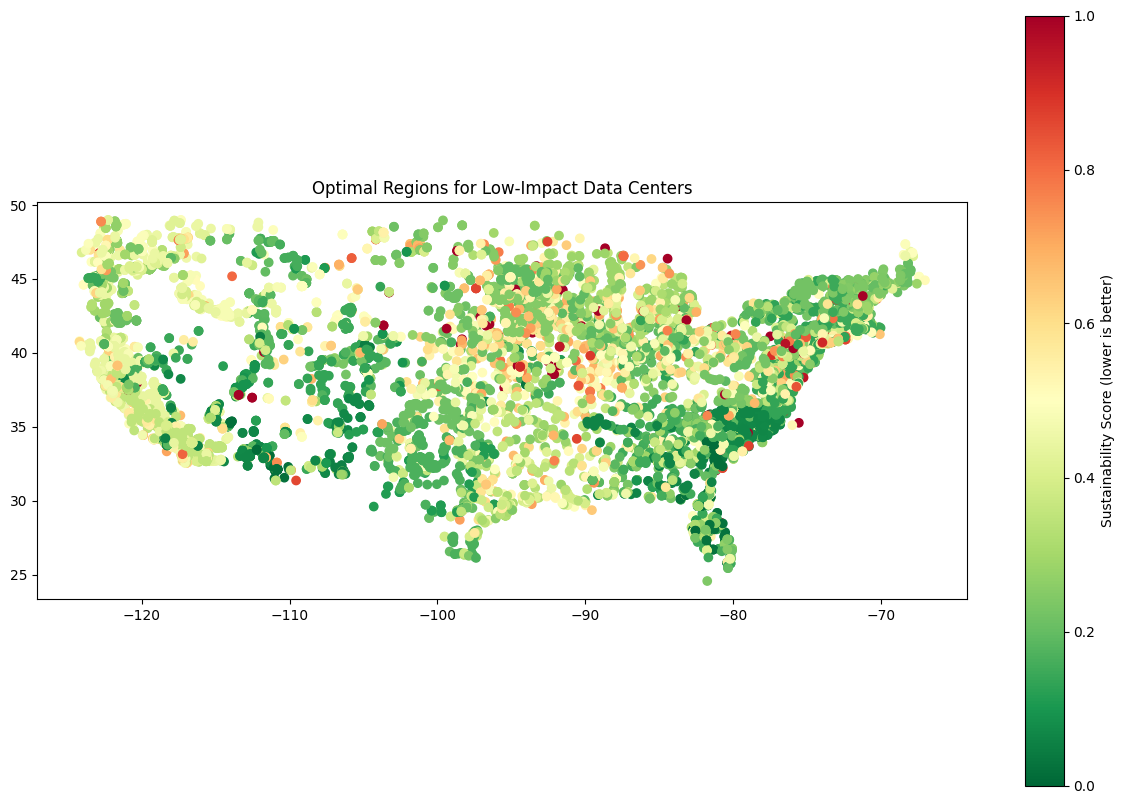

Top 10 Recommended Regions for Low-Impact Data Centers:
PCA Name
JEA                                        0.084399
Duke Energy Progress East                  0.110220
Southeastern Power Administration          0.140477
Arizona Public Service Company             0.143818
Tucson Electric Power Company              0.148305
Public Service Company of New Mexico       0.149214
Salt River Project                         0.150083
El Paso Electric Company                   0.156813
Duke Energy Carolinas                      0.181578
South Carolina Public Service Authority    0.189417
Name: sustainability_score, dtype: float64


In [68]:


x, y, z = 0.3, 0.4, 0.3
df1_2_4_5['sustainability_score'] = (
    x * (df1_2_4_5['Carbon intensity (Tons/MWh)']+df1_2_4_5['Water intensity (m3/MWh)']) +
    y * df1_2_4_5['renewable_fraction'] +
    z * (df1_2_4_5['Infrastructure score'])
)

# --- 4. Create GeoDataFrame for plotting ---
geometry = [Point(xy) for xy in zip(df1_2_4_5['Longitude'], df1_2_4_5['Latitude'])]
geo_df = gpd.GeoDataFrame(df1_2_4_5, geometry=geometry)

# Create a map of sustainability scores by region
fig, ax = plt.subplots(figsize=(15, 10))
geo_df.plot(
    column='sustainability_score',
    cmap='RdYlGn_r',
    legend=True,
    legend_kwds={'label': "Sustainability Score (lower is better)"},
    ax=ax,
    vmin=0,
    vmax=1
)
plt.title('Optimal Regions for Low-Impact Data Centers')
plt.show()

# --- 6. Identify and print top 10 recommended regions ---
region_scores = df1_2_4_5.groupby('PCA Name')['sustainability_score'].mean()
top_regions = region_scores.sort_values().head(10)
print("Top 10 Recommended Regions for Low-Impact Data Centers:")
print(top_regions)


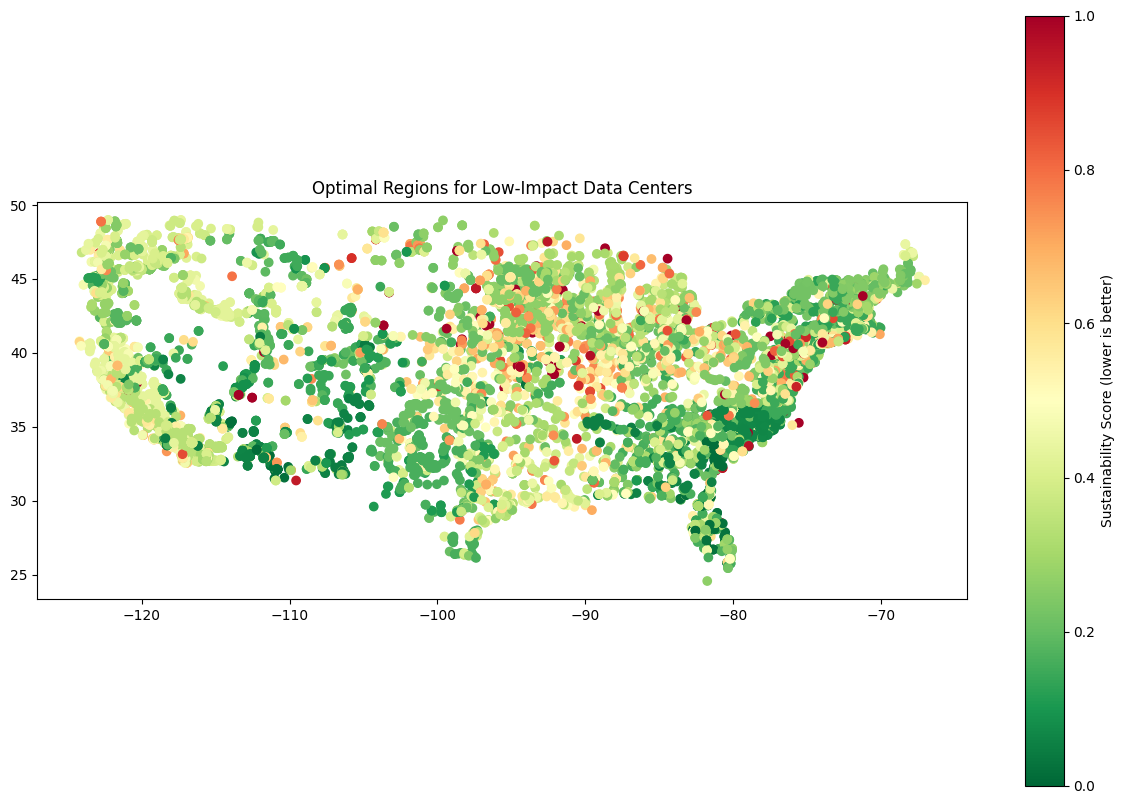

Top 10 Recommended Regions for Low-Impact Data Centers:
PCA Name
JEA                                     0.090906
Duke Energy Progress East               0.113576
Southeastern Power Administration       0.146537
Arizona Public Service Company          0.148480
Public Service Company of New Mexico    0.149807
Salt River Project                      0.154258
Tucson Electric Power Company           0.157137
El Paso Electric Company                0.157304
Duke Energy Carolinas                   0.192316
Portland General Electric Company       0.196346
Name: dynamic_sustainability_score, dtype: float64


In [69]:


# Apply to entire dataset
df1_2_4_5['dynamic_weights'] = df1_2_4_5.apply(
    lambda row: get_dynamic_weights(
        row['Carbon intensity (Tons/MWh)'],
        row['Water intensity (m3/MWh)'],
        row['renewable_fraction'],
        row['Infrastructure score'],
    ),
    axis=1
)

# Calculate dynamic sustainability score
df1_2_4_5['dynamic_sustainability_score'] = df1_2_4_5.apply(
    lambda row: sustainability_score(
        row['Carbon intensity (Tons/MWh)'],
        row['Water intensity (m3/MWh)'],
        row['renewable_fraction'],
        row['Infrastructure score'],
    ),
    axis=1
)

# --- 4. Create GeoDataFrame for plotting ---
geometry = [Point(xy) for xy in zip(df1_2_4_5['Longitude'], df1_2_4_5['Latitude'])]
geo_df = gpd.GeoDataFrame(df1_2_4_5, geometry=geometry)

# Create a map of sustainability scores by region
fig, ax = plt.subplots(figsize=(15, 10))
geo_df.plot(
    column='dynamic_sustainability_score',
    cmap='RdYlGn_r',
    legend=True,
    legend_kwds={'label': "Sustainability Score (lower is better)"},
    ax=ax,
    vmin=0,
    vmax=1
)
plt.title('Optimal Regions for Low-Impact Data Centers')
plt.show()

# --- 6. Identify and print top 10 recommended regions ---
region_scores = df1_2_4_5.groupby('PCA Name')['dynamic_sustainability_score'].mean()
top_regions = region_scores.sort_values().head(10)
print("Top 10 Recommended Regions for Low-Impact Data Centers:")
print(top_regions)


In [70]:
print(df1_2_4_5[['dynamic_sustainability_score', 'sustainability_score']])

       dynamic_sustainability_score  sustainability_score
0                          0.321773              0.298190
1                          0.198946              0.187646
2                          0.204576              0.192713
3                          0.393526              0.362768
4                          0.393579              0.362815
...                             ...                   ...
10948                      0.271451              0.252493
10949                      0.644027              0.587812
10950                      0.636344              0.580897
10951                      0.626558              0.572090
10952                      0.695694              0.644024

[10953 rows x 2 columns]


In [71]:
print(df1_2_4_5['dynamic_weights'])

0        [0.13117899, 0.13117899, 0.73764205]
1        [0.14040725, 0.14040725, 0.71918553]
2           [0.1403989, 0.1403989, 0.7192022]
3         [0.14858092, 0.14858092, 0.7028382]
4        [0.14856222, 0.14856222, 0.70287555]
                         ...                 
10948    [0.15238208, 0.15238208, 0.69523585]
10949    [0.14503217, 0.14503217, 0.70993567]
10950     [0.14469996, 0.14469996, 0.7106001]
10951    [0.14428286, 0.14428286, 0.71143425]
10952     [0.13764635, 0.13764635, 0.7247073]
Name: dynamic_weights, Length: 10953, dtype: object


In [76]:
print(df1_2_4_5['dynamic_sustainability_score'].describe())
print(df1_2_4_5['sustainability_score'].describe())

count    10953.000000
mean         0.332210
std          0.406277
min          0.002880
25%          0.163594
50%          0.293060
75%          0.431852
max         20.514629
Name: dynamic_sustainability_score, dtype: float64
count    10953.000000
mean         0.323494
std          0.368885
min          0.003364
25%          0.162253
50%          0.285002
75%          0.438272
max         18.482092
Name: sustainability_score, dtype: float64


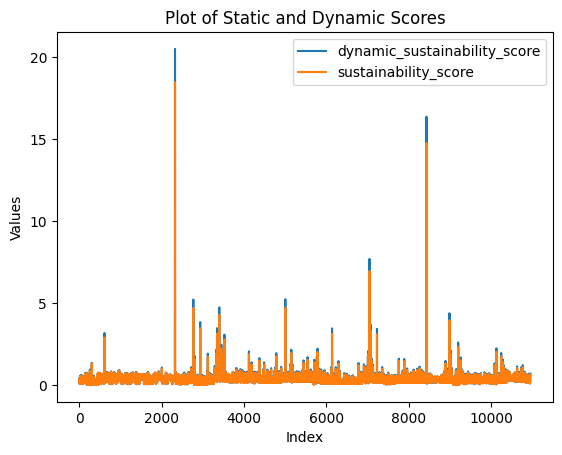

In [77]:
#Dynamic Sustainability Score vs Static Sustainability Score

plt.plot(df1_2_4_5['dynamic_sustainability_score'], label='dynamic_sustainability_score')
plt.plot(df1_2_4_5['sustainability_score'], label='sustainability_score')

# Adding labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Plot of Static and Dynamic Scores')

# Adding legend
plt.legend()

# Displaying the plot
plt.show()

#Driver code for Future Scope

In [ ]:
# The following code can be used in the future scope to get the various values and use them for sustainability score calculation for the dataset
# net_gen = df1_2_4_5['Net generation (MWh)'][103]
# gen_ratio = df1_2_4_5['Generation Ratio of Power plant'][103]
# plant_fuel = df1_2_4_5['Plant primary fuel code'][103]
# huc8id = df1_2_4_5['HUC8 ID'][103]
# plant_state = df1_2_4_5['Plant state'][103]
# bac = df1_2_4_5['Balancing Authority Code'][103]
# water_cons = df1_2_4_5['Water Consumption (m3)'][103]
# lat = df1_2_4_5['Latitude'][103]
# lon = df1_2_4_5['Longitude'][103]
# fuel_code = df1_2_4_5['Plant primary fuel code'][103]
# plant_id = df1_2_4_5['Plant Id'][103]

# geo_cluster = geo_cluster_calc(lat, lon)
# fuel_category = fuel_category_calc(fuel_code)
# co2e = co2_emission_calc(net_gen, geo_cluster, fuel_category, gen_ratio, plant_fuel, huc8id, plant_state, bac)
# water_efficiency = water_efficiency_ratio_calc(net_gen, water_cons)
# water_int = water_intensity_calc(water_cons, fuel_category, water_efficiency, huc8id, bac, plant_fuel, net_gen)
# carbon_int = co2e/net_gen
# ren_fraction = get_renewable_fraction(group_col, bac)
# infra_score = get_infrastructure_score(fuel_code, bac, plant_id)

# weights = get_dynamic_weights(carbon_int, water_int, ren_fraction, infra_score, 0)
